In [1]:
import pandas as pd
import numpy as np
from utils import *
import seaborn as sns
import matplotlib.pyplot as plt
data = pd.read_csv('data/train.csv')

In [2]:
# 查看变量属性
features_categorize = categorize_columns(df = data, max_discrete_number=200)
images = plot_categorize_columns_results(features_categorize)
images.render_notebook()

In [3]:
# 处理Object类型
# 1.grade完全由subGrade多对一确定，删除grade，并将subGrade进行one-hot编码,但由于F1-G5样本太小，故将F1-F5合并为F，G1-G5合并为G
# 2.title属性，无意义，删除
# 3.employmentLenth共十种取值，转为one-hot编码（后续模型不允许列名中含有'<',故改名）
# 4.earliesCreditLine和issueDate属性属于月份，取值多且有明显的连续属性，用utils.transform_date_to_int_by_order函数，按先后顺序转化为数字
data['earliesCreditLine'] = transform_date_to_int_by_order(data['earliesCreditLine'])
data['issueDate'] = transform_date_to_int_by_order(data['issueDate'])
employmentLength_dummies = pd.get_dummies(data['employmentLength'])
employmentLength_dummies.rename(columns={'< 1 year': 'less than 1 year'}, inplace=True)
employmentLength_dummies.rename(columns={'10+ years': 'more than 10 years'}, inplace=True)

subGrade_dummies = pd.get_dummies(data['subGrade'])
subGrade_dummies['sum_F'] = subGrade_dummies.loc[:, subGrade_dummies.columns.str.match('^F\w{1}$')].sum(axis=1)
subGrade_dummies['sum_G'] = subGrade_dummies.loc[:, subGrade_dummies.columns.str.match('^G\w{1}$')].sum(axis=1)
subGrade_dummies.drop(subGrade_dummies.columns[subGrade_dummies.columns.str.match('^G\w{1}$')], inplace=True, axis=1)
subGrade_dummies.drop(subGrade_dummies.columns[subGrade_dummies.columns.str.match('^F\w{1}$')], inplace=True, axis=1)

data = pd.concat([data, employmentLength_dummies], axis=1)
data = pd.concat([data, subGrade_dummies], axis=1)
data.drop(['title', 'employmentLength', 'subGrade', 'grade'], inplace=True, axis=1)

In [4]:
# 对部分有偏数据进行放缩，需要进行放缩的变量以及其放缩比例保存在configs/data_clean.yml中
config_path = 'configs/data_clean.yml'
with open(config_path, 'r') as file:
    config_data = yaml.safe_load(file)
for feature_name in config_data['power_size']:
    data[feature_name] = np.power(data[feature_name], config_data['power_size'][feature_name])

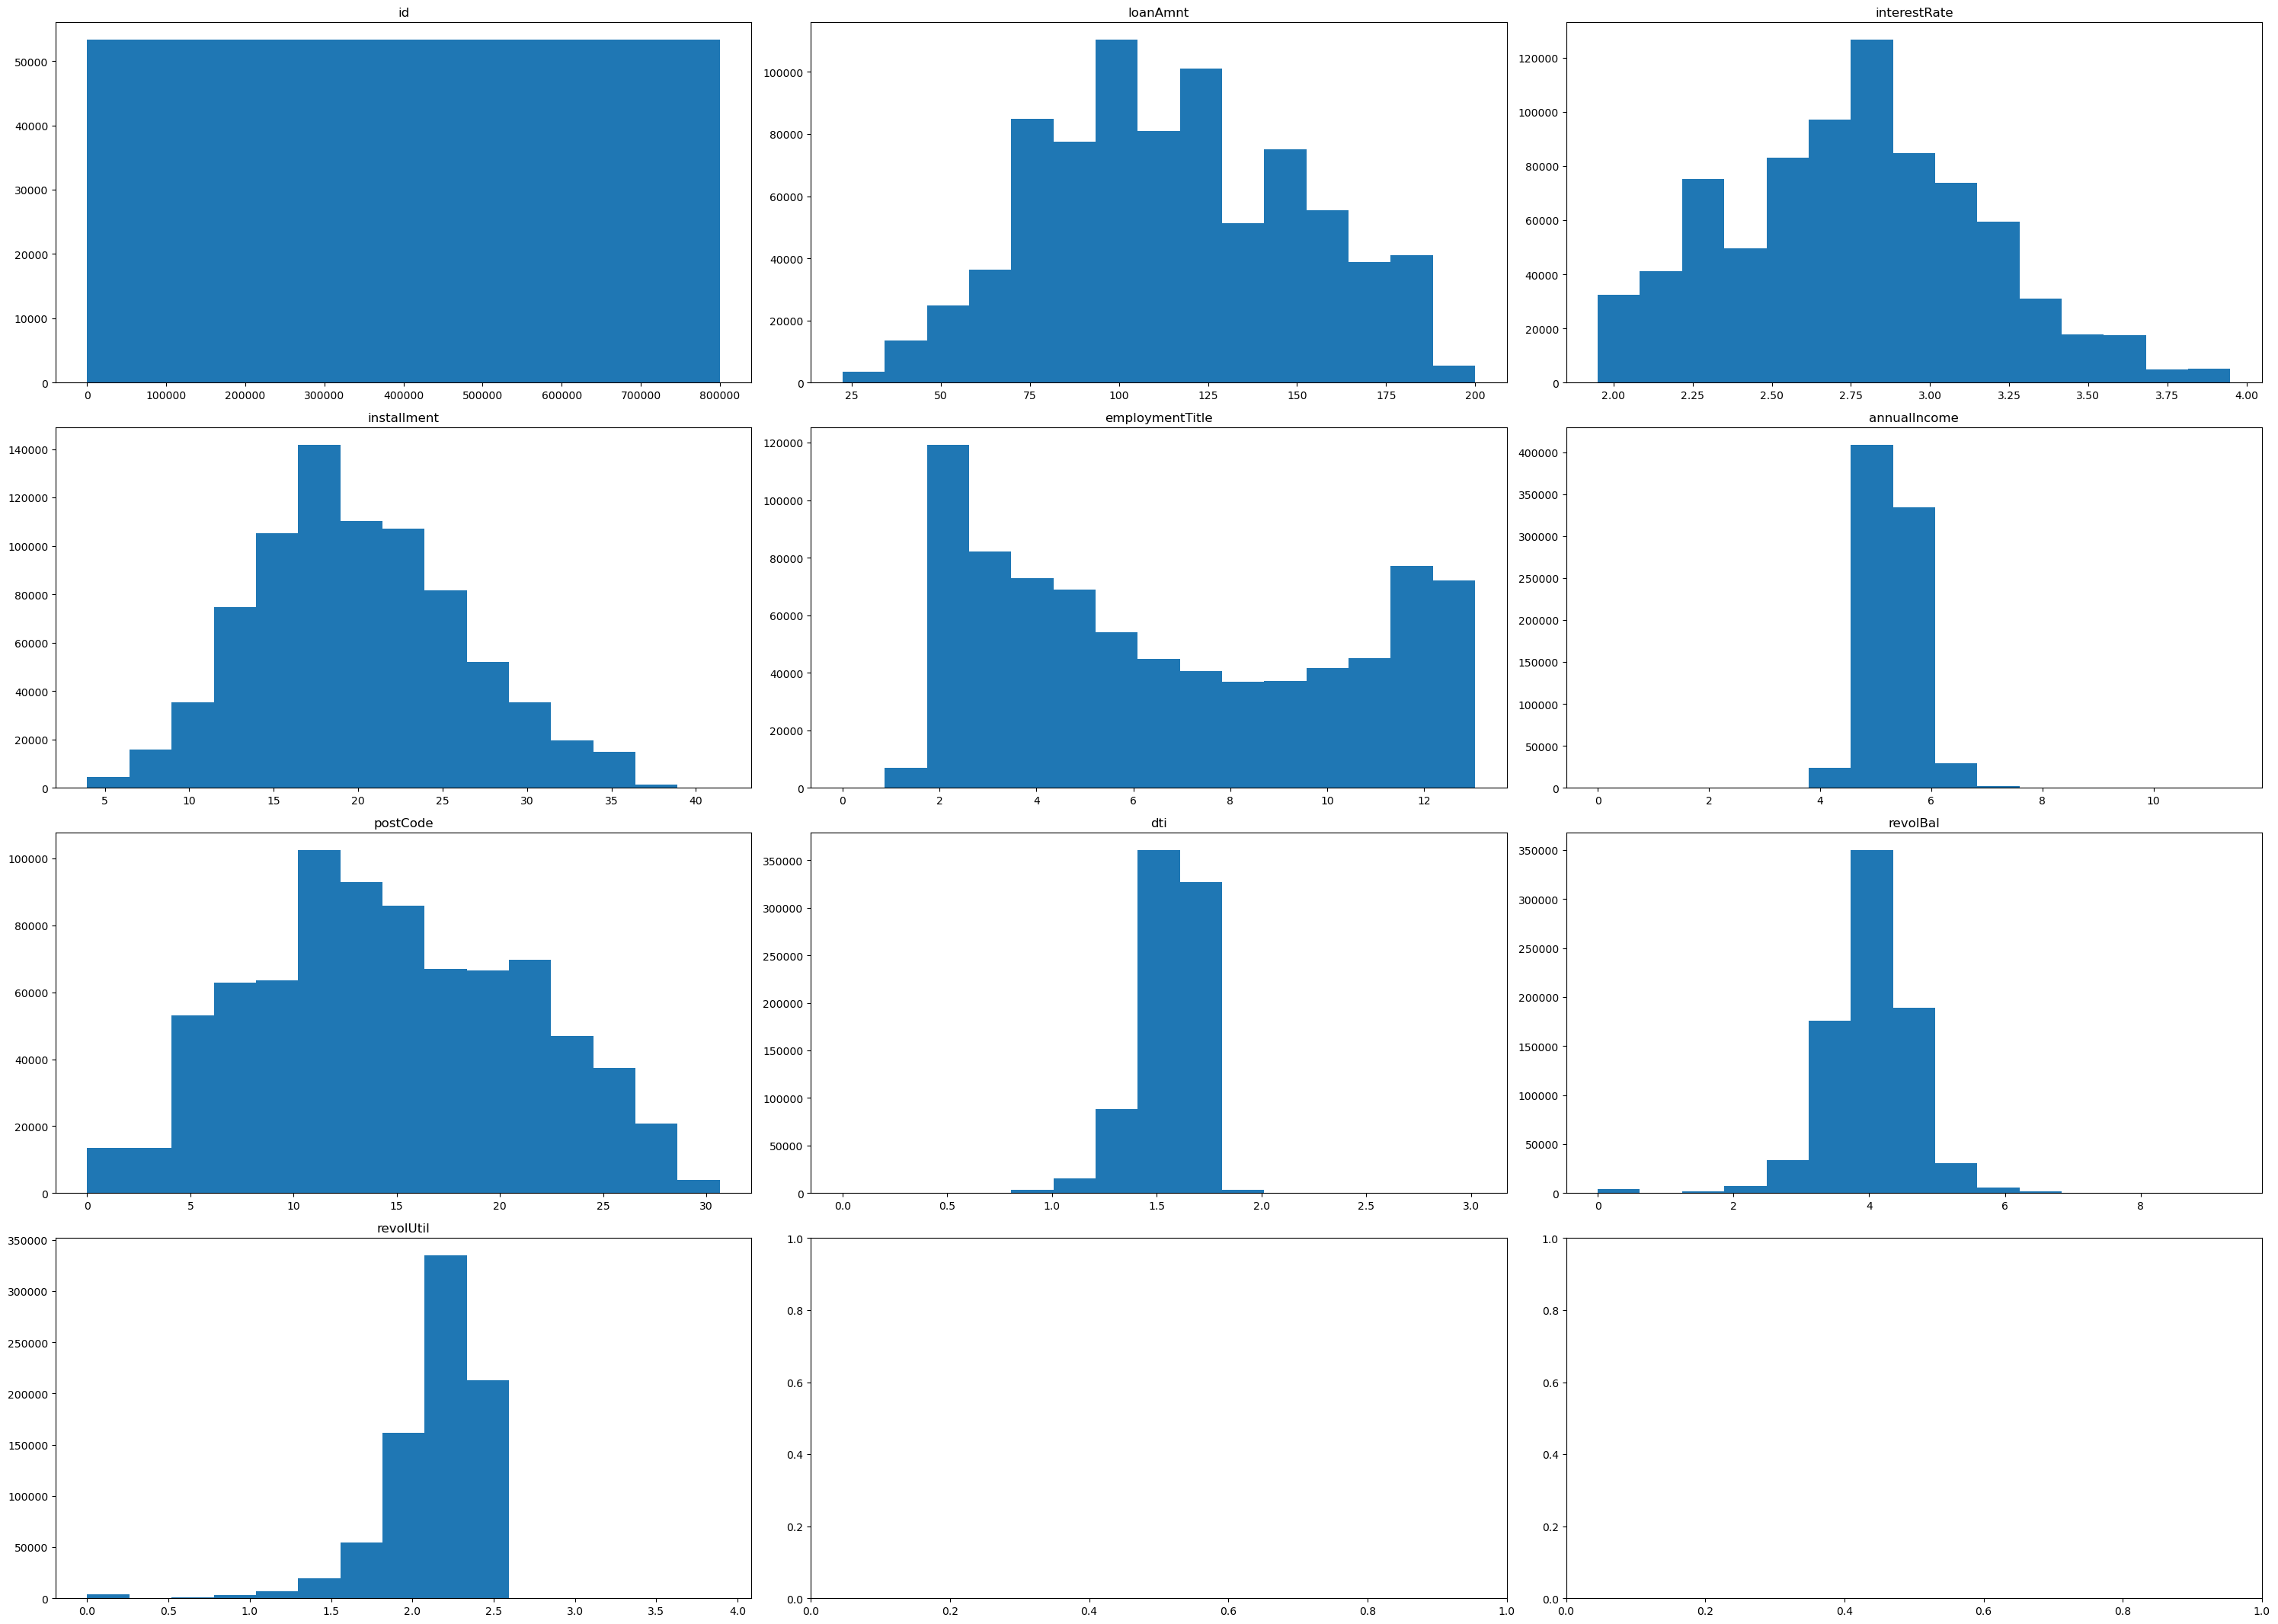

In [9]:
# 查看连续型变量
continuous_features = [column_name for column_name in features_categorize['continuous'] if column_name in data.columns.values]
plot_different_features(data[continuous_features], plot_method='hist')

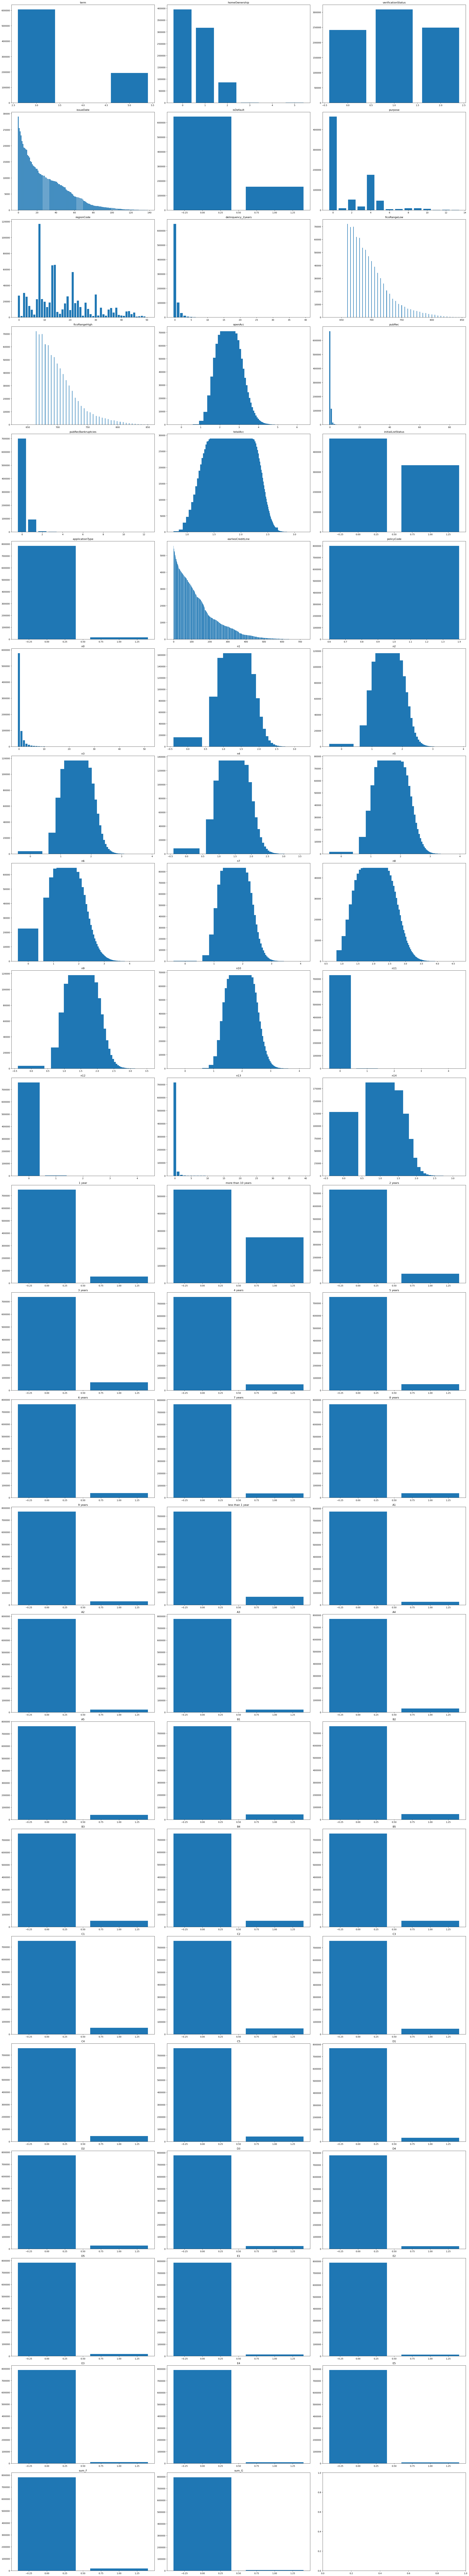

In [12]:
# 查看离散变量
discrete_features = [column_name for column_name in data.columns.values if column_name not in continuous_features]
plot_different_features(data[discrete_features], plot_method='bar')

In [18]:
# 至此完成了大部分数据清洗工作，检查空值
data.isna().sum()[data.isna().sum()!=0]/len(data)

employmentTitle       0.000001
postCode              0.000001
dti                   0.000301
pubRecBankruptcies    0.000506
revolUtil             0.000664
n0                    0.050338
n1                    0.050338
n2                    0.050338
n3                    0.050338
n4                    0.041549
n5                    0.050338
n6                    0.050338
n7                    0.050338
n8                    0.050339
n9                    0.050338
n10                   0.041549
n11                   0.087190
n12                   0.050338
n13                   0.050338
n14                   0.050338
dtype: float64

In [19]:
# 发现20列中有空值，且最多空值比例5%，以众数填充
data = data.apply(lambda x : x.fillna(x.mode().iloc[0]), axis=0)

In [23]:
data.info()
# 至此，完成了数据清洗工作，目前得到了一个[800000, 80]的数据集，其中79列为X，1列为y

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 81 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  800000 non-null  int64  
 1   loanAmnt            800000 non-null  float64
 2   term                800000 non-null  int64  
 3   interestRate        800000 non-null  float64
 4   installment         800000 non-null  float64
 5   employmentTitle     800000 non-null  float64
 6   homeOwnership       800000 non-null  int64  
 7   annualIncome        800000 non-null  float64
 8   verificationStatus  800000 non-null  int64  
 9   issueDate           800000 non-null  int64  
 10  isDefault           800000 non-null  int64  
 11  purpose             800000 non-null  int64  
 12  postCode            800000 non-null  float64
 13  regionCode          800000 non-null  int64  
 14  dti                 800000 non-null  float64
 15  delinquency_2years  800000 non-nul

In [ ]:
data.to_csv('data/data_after_clean.csv')